# Serial Killer with Data

### Use Case:

Understanding crime patterns and trends is crucial for making data-driven decisions in law enforcement and policy-making. For this demonstration, we’ll leverage the Murder Accountability Project’s extensive dataset, which includes homicide information spanning decades in the United States. Our goal is to make this data clean, complete, and informative — suitable for predictive tasks like clearance rate prediction, offender profiling, and hotspot analysis. Each step we take in transforming this data will be designed to answer specific questions and create actionable insights for real-world applications

In [1]:
# Step 1: Load the Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://github.com/fenago/datasets/raw/refs/heads/main/SHR65_23.zip')
df.head()

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,197603001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,March,...,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
1,197604001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,April,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Girlfriend,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
2,197606001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,June,...,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Other,NaN,0,0,30180.0,"Anchorage, AK"
3,197606002AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,June,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Other - known to victim,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
4,197607001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,July,...,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"


In [2]:
# Step 2: Generate Data Quality Report 1 (DQR1

def generate_dqr1(df):
    # Initialize an empty DataFrame to store DQR1 results
    dqr1_df = pd.DataFrame(index=df.columns)

    # Basic Column Statistics
    dqr1_df['Missing_Values'] = df.isnull().sum()
    dqr1_df['Unique_Values'] = df.nunique()

    # Sample Value Counts (stored as a list to avoid multiple columns issue)
    dqr1_df['Sample_Value_Counts'] = df.apply(lambda x: list(x.value_counts().head(3).to_dict().items()))

    # Separate numeric and non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    non_numeric_df = df.select_dtypes(exclude=[np.number])

    # Descriptive Statistics for Numeric Columns Only
    descriptive_stats = numeric_df.describe().T
    stats_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    for col in stats_columns:
        dqr1_df[col] = descriptive_stats[col]

    # Convert stats columns to object type for safe assignment
    dqr1_df[stats_columns] = dqr1_df[stats_columns].astype(object)

    # Mark irrelevant stats for non-numeric columns
    dqr1_df.loc[non_numeric_df.columns, stats_columns] = 'N/A'

    # Correlation Analysis for Numeric Columns Only
    corr_matrix = numeric_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
    dqr1_df['Highly_Correlated'] = dqr1_df.index.isin(highly_correlated)

    # Variance Analysis for Numeric Columns Only
    variances = numeric_df.var()
    dqr1_df['High_Variance'] = dqr1_df.index.map(lambda x: variances[x] > 1.0 if x in variances else 'N/A')
    dqr1_df['Low_Variance'] = dqr1_df.index.map(lambda x: variances[x] < 0.01 if x in variances else 'N/A')

    # Potential Index Columns
    dqr1_df['Potential_Index'] = dqr1_df['Unique_Values'] > len(df) * 0.9

    # Additional Column Type Info
    dqr1_df['Data_Type'] = df.dtypes

    # Display the complete Data Quality Report with all rows and columns
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    display(dqr1_df)

    return dqr1_df

# Generate the Data Quality Report
dqr1_df = generate_dqr1(df)


,Missing_Values,Unique_Values,Sample_Value_Counts,mean,std,min,25%,50%,75%,max,Highly_Correlated,High_Variance,Low_Variance,Potential_Index,Data_Type
ID,0,852394,"[(197702001NY05904, 13), (199204001FL05003, 12...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,True,object
CNTYFIPS,0,3079,"[(Los Angeles, CA, 55681), (New York, NY, 4780...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
Ori,0,13442,"[(NY03030, 47790), (ILCPD00, 30509), (CA01942,...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
State,0,51,"[(California, 129741), (Texas, 86288), (New Yo...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
Agency,0,10015,"[(New York, 47790), (Chicago, 30509), (Los Ang...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
Agentype,0,8,"[(Municipal police, 692613), (Sheriff, 150999)...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
Source,0,2,"[(FBI, 855718), (MAP, 38918)]",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
Solved,0,2,"[(Yes, 632457), (No, 262179)]",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object
Year,0,48,"[(1993, 24337), (1992, 23793), (2021, 23699)]",1998.868617,14.134767,1976.0,1987.0,1997.0,2011.0,2023.0,False,True,False,False,int64
Month,0,12,"[(July, 82444), (August, 80644), (December, 76...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,False,object


In [3]:
# Step 3: Generate a Detailed Data Quality Report with Recommendations

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, OneHotEncoder, OrdinalEncoder
import pandas as pd

def generate_data_quality_report_analysis(dqr1_df):
    # Initialize a new DataFrame to store the analysis
    analysis_df = dqr1_df[['Data_Type']].copy()  # Start with only Data_Type for essential columns

    # Add columns for analysis
    analysis_df['Treat_Flag'] = False  # Flag indicating if treatment is needed
    analysis_df['Outliers'] = False    # Flag indicating if outliers are detected
    analysis_df['Scale'] = False       # Flag for scaling recommendation
    analysis_df['Encode'] = False      # Flag for encoding recommendation

    # New True/False columns
    analysis_df['Missing_Values_Flag'] = False
    analysis_df['Infinities_Flag'] = False
    analysis_df['Correct_Data_Type'] = True
    analysis_df['Correlated_Columns_Flag'] = False

    # Additional columns to be ordered last
    analysis_df['Potential_Issues'] = ""  # Column to describe potential issues
    analysis_df['Recommendations'] = ""  # Column to provide recommendations
    analysis_df['Severity'] = "Severity 3: Optional considerations for improved quality"  # Default severity

    # 1. Missing Values Analysis (including % missing by column)
    missing_cols = dqr1_df[dqr1_df['Missing_Values'] > 0]
    for col in missing_cols.index:
        missing_percentage = (missing_cols['Missing_Values'][col] / len(dqr1_df)) * 100
        analysis_df.loc[col, 'Missing_Values_Flag'] = True
        analysis_df.loc[col, 'Potential_Issues'] += f"Missing values: {missing_percentage:.2f}%"
        analysis_df.loc[col, 'Treat_Flag'] = True
        analysis_df.loc[col, 'Severity'] = (
            "Severity 1: Issues that must be addressed" if missing_percentage > 50
            else "Severity 2: Significant quality issues that impact model performance"
        )
        if missing_percentage > 30:
            analysis_df.loc[col, 'Recommendations'] += "Consider dropping or using advanced imputation if critical."
        else:
            analysis_df.loc[col, 'Recommendations'] += "Simple imputation recommended (mean/median for numeric, mode for categorical)."

    # Additional missing values analysis: missing by row
    row_missing_percentage = (dqr1_df.isnull().sum(axis=1) / len(dqr1_df.columns)) * 100
    analysis_df.loc[:, 'Potential_Issues'] += f"\nRows with missing values exceeding 20%: {sum(row_missing_percentage > 20)}"

    # 2. Unique Values Analysis and Curse of Dimensionality Check
    high_cardinality_cols = dqr1_df[dqr1_df['Potential_Index'] == True]
    for col in high_cardinality_cols.index:
        analysis_df.loc[col, 'Potential_Issues'] += "High cardinality (potential identifier)."
        analysis_df.loc[col, 'Treat_Flag'] = True
        analysis_df.loc[col, 'Recommendations'] += "Consider dropping or indexing if needed."
        analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"

    # Check for potential curse of dimensionality for categorical columns with high unique values
    for col in analysis_df.index:
        if dqr1_df['Data_Type'][col] == 'object' and dqr1_df['Unique_Values'][col] > 50:
            analysis_df.loc[col, 'Potential_Issues'] += "High unique values; may suffer from curse of dimensionality on encoding."
            analysis_df.loc[col, 'Treat_Flag'] = True
            analysis_df.loc[col, 'Encode'] = True
            analysis_df.loc[col, 'Recommendations'] += "Consider using OrdinalEncoder, feature hashing, or get_dummies if appropriate."
            analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"

    # 3. Descriptive Statistics Analysis, Outlier Detection, and Scaling Recommendations
    for col in analysis_df.index:
        if dqr1_df['mean'][col] != 'N/A':
            mean_val, min_val, max_val = dqr1_df['mean'][col], dqr1_df['min'][col], dqr1_df['max'][col]
            iqr = dqr1_df['75%'][col] - dqr1_df['25%'][col]
            lower_bound, upper_bound = dqr1_df['25%'][col] - 1.5 * iqr, dqr1_df['75%'][col] + 1.5 * iqr
            # Check for outliers
            if (max_val > upper_bound) or (min_val < lower_bound):
                analysis_df.loc[col, 'Outliers'] = True
                analysis_df.loc[col, 'Potential_Issues'] += " Outliers detected."
                analysis_df.loc[col, 'Recommendations'] += " Consider outlier treatment (e.g., capping, transformation)."
                analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"
            # Scaling recommendation
            if max_val - min_val > 1000:
                analysis_df.loc[col, 'Scale'] = True
                analysis_df.loc[col, 'Potential_Issues'] += " High range detected."
                analysis_df.loc[col, 'Recommendations'] += " Consider scaling using StandardScaler or RobustScaler."
                analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"
            # Check for infinities
            if min_val == float('-inf') or max_val == float('inf'):
                analysis_df.loc[col, 'Infinities_Flag'] = True
                analysis_df.loc[col, 'Potential_Issues'] += " Contains positive or negative infinity values."
                analysis_df.loc[col, 'Treat_Flag'] = True
                analysis_df.loc[col, 'Recommendations'] += " Consider handling infinity values by replacing or capping."
                analysis_df.loc[col, 'Severity'] = "Severity 1: Issues that must be addressed"
            else:
                # Additional scaler recommendations
                analysis_df.loc[col, 'Recommendations'] += " Alternative scaling options: MinMaxScaler, PowerTransformer, or QuantileTransformer."

    # 4. Variance Analysis
    low_variance_cols = dqr1_df[dqr1_df['Low_Variance'] == True]
    for col in low_variance_cols.index:
        analysis_df.loc[col, 'Potential_Issues'] += " Low variance detected."
        analysis_df.loc[col, 'Treat_Flag'] = True
        analysis_df.loc[col, 'Recommendations'] += " Consider dropping due to low variance."
        analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"

    # 5. Correlation Analysis
    highly_correlated_cols = dqr1_df[dqr1_df['Highly_Correlated'] == True]
    for col in highly_correlated_cols.index:
        analysis_df.loc[col, 'Correlated_Columns_Flag'] = True
        analysis_df.loc[col, 'Potential_Issues'] += " High correlation with other columns."
        analysis_df.loc[col, 'Treat_Flag'] = True
        analysis_df.loc[col, 'Recommendations'] += " Consider removing redundant columns or using PCA."
        analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"

    # 6. Data Type and Encoding Analysis
    for col in analysis_df.index:
        if analysis_df['Data_Type'][col] == 'object':
            analysis_df.loc[col, 'Correct_Data_Type'] = False
            analysis_df.loc[col, 'Potential_Issues'] += " Categorical data type detected."
            analysis_df.loc[col, 'Treat_Flag'] = True
            analysis_df.loc[col, 'Encode'] = True
            if dqr1_df['Unique_Values'][col] <= 10:
                analysis_df.loc[col, 'Recommendations'] += " Use OneHotEncoder or pd.get_dummies for encoding."
            else:
                analysis_df.loc[col, 'Recommendations'] += " Use OrdinalEncoder or feature hashing to handle high cardinality."
            analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"
        elif pd.api.types.is_numeric_dtype(analysis_df['Data_Type'][col]) and dqr1_df['Potential_Index'][col] == True:
            analysis_df.loc[col, 'Potential_Issues'] += " Potential index with high cardinality."
            analysis_df.loc[col, 'Recommendations'] += " Consider converting to `category` type to save memory."
        elif analysis_df['Data_Type'][col] == 'object' and dqr1_df['Unique_Values'][col] > 50:
            analysis_df.loc[col, 'Potential_Issues'] += " Potential text column detected; consider for NLP analysis."
            analysis_df.loc[col, 'Treat_Flag'] = True
            analysis_df.loc[col, 'Recommendations'] += " Consider using NLP techniques for text analysis."
            analysis_df.loc[col, 'Severity'] = "Severity 2: Significant quality issues that impact model performance"

    # 7. Duplicate Check (removing unhashable types)
    hashable_df = dqr1_df.applymap(lambda x: x if isinstance(x, (str, int, float, bool, pd.Timestamp)) else None)
    duplicate_rows = hashable_df.duplicated().sum()
    if duplicate_rows > 0:
        analysis_df.loc[:, 'Potential_Issues'] += f"\nDataset contains {duplicate_rows} duplicate rows."
        analysis_df.loc[:, 'Treat_Flag'] = True
        analysis_df.loc[:, 'Recommendations'] += " Consider removing duplicate rows to improve data quality."
        analysis_df.loc[:, 'Severity'] = "Severity 1: Issues that must be addressed"

    # 8. Potential Index Columns Check
    potential_index_cols = [col for col in dqr1_df.index if dqr1_df['Unique_Values'][col] == len(dqr1_df)]
    if potential_index_cols:
        for col in potential_index_cols:
            analysis_df.loc[col, 'Potential_Issues'] += " Unique values for each row; could serve as index."
            analysis_df.loc[col, 'Recommendations'] += " Consider using this column as an index."
            analysis_df.loc[col, 'Severity'] = "Severity 3: Optional considerations for improved quality"

    # Sort by 'Severity' and 'Treat_Flag' for priority order
    analysis_df = analysis_df.sort_values(by=['Severity', 'Treat_Flag'], ascending=[True, False])

    # Reorder columns: True/False flags first, followed by analysis columns, and ending with `Data_Type`, `Potential_Issues`, and `Recommendations`
    column_order = [
        'Treat_Flag', 'Outliers', 'Scale', 'Encode', 'Missing_Values_Flag', 'Infinities_Flag',
        'Correct_Data_Type', 'Correlated_Columns_Flag', 'Severity', 'Data_Type', 'Potential_Issues', 'Recommendations'
    ]
    analysis_df = analysis_df[column_order]

    # Ensure Potential_Issues and Recommendations are fully readable
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)

    # Display the Data Quality Report Analysis
    display(analysis_df)

    return analysis_df

# Generate the analysis report based on dqr1_df
analysis_df = generate_data_quality_report_analysis(dqr1_df)


C:\Users\sudwa\AppData\Local\Temp\ipykernel_11504\2408465996.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hashable_df = dqr1_df.applymap(lambda x: x if isinstance(x, (str, int, float, bool, pd.Timestamp)) else None)


,Treat_Flag,Outliers,Scale,Encode,Missing_Values_Flag,Infinities_Flag,Correct_Data_Type,Correlated_Columns_Flag,Severity,Data_Type,Potential_Issues,Recommendations
ID,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0High cardinality (potential identifier).High unique values; may suffer from curse of dimensionality on encoding. Categorical data type detected.\nDataset contains 8 duplicate rows.,"Consider dropping or indexing if needed.Consider using OrdinalEncoder, feature hashing, or get_dummies if appropriate. Use OrdinalEncoder or feature hashing to handle high cardinality. Consider removing duplicate rows to improve data quality."
CNTYFIPS,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0High unique values; may suffer from curse of dimensionality on encoding. Categorical data type detected.\nDataset contains 8 duplicate rows.,"Consider using OrdinalEncoder, feature hashing, or get_dummies if appropriate. Use OrdinalEncoder or feature hashing to handle high cardinality. Consider removing duplicate rows to improve data quality."
Ori,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0High unique values; may suffer from curse of dimensionality on encoding. Categorical data type detected.\nDataset contains 8 duplicate rows.,"Consider using OrdinalEncoder, feature hashing, or get_dummies if appropriate. Use OrdinalEncoder or feature hashing to handle high cardinality. Consider removing duplicate rows to improve data quality."
State,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0High unique values; may suffer from curse of dimensionality on encoding. Categorical data type detected.\nDataset contains 8 duplicate rows.,"Consider using OrdinalEncoder, feature hashing, or get_dummies if appropriate. Use OrdinalEncoder or feature hashing to handle high cardinality. Consider removing duplicate rows to improve data quality."
Agency,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0High unique values; may suffer from curse of dimensionality on encoding. Categorical data type detected.\nDataset contains 8 duplicate rows.,"Consider using OrdinalEncoder, feature hashing, or get_dummies if appropriate. Use OrdinalEncoder or feature hashing to handle high cardinality. Consider removing duplicate rows to improve data quality."
Agentype,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0 Categorical data type detected.\nDataset contains 8 duplicate rows.,Use OneHotEncoder or pd.get_dummies for encoding. Consider removing duplicate rows to improve data quality.
Source,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0 Categorical data type detected.\nDataset contains 8 duplicate rows.,Use OneHotEncoder or pd.get_dummies for encoding. Consider removing duplicate rows to improve data quality.
Solved,True,False,False,True,False,False,False,False,Severity 1: Issues that must be addressed,object,\nRows with missing values exceeding 20%: 0 Categorical data type detected.\nDataset contains 8 duplicate rows.,Use OneHotEncoder or pd.get_dummies for encoding. Consider removing duplicate rows to improve data quality.
Year,True,False,False,False,False,False,True,False,Severity 1: Issues that must be addressed,int64,\nRows with missing values exceeding 20%: 0\nDataset contains 8 duplicate rows.,"Alternative scaling options: MinMaxScaler, PowerTransformer, or QuantileTransformer. Consider removing duplicate rows to improve data quality."
Month,True,Fals

In [4]:
# Step 4: Action Plan — Data Quality Treatment with Code Integration
from IPython.display import display, HTML

def generate_action_plan_with_code(analysis_df, dqr1_df):
    # Collect columns for each specific action based on the analysis
    duplicate_rows = analysis_df[analysis_df['Treat_Flag'] & analysis_df['Potential_Issues'].str.contains("duplicate rows")].index.tolist()
    missing_value_cols = analysis_df[analysis_df['Missing_Values_Flag']].index.tolist()
    high_cardinality_cols = analysis_df[(analysis_df['Encode']) & (analysis_df['Potential_Issues'].str.contains("High cardinality"))].index.tolist()
    outlier_cols = analysis_df[analysis_df['Outliers']].index.tolist()
    high_range_cols = analysis_df[analysis_df['Scale']].index.tolist()
    incorrect_data_type_cols = analysis_df[~analysis_df['Correct_Data_Type']].index.tolist()
    low_variance_cols = analysis_df[analysis_df['Potential_Issues'].str.contains("Low variance detected")].index.tolist()
    highly_correlated_cols = analysis_df[analysis_df['Correlated_Columns_Flag']].index.tolist()
    potential_index_cols = dqr1_df[dqr1_df['Potential_Index']].index.tolist()

    # Action plan with explanations, actions, and sample code
    action_plan = f"""
    ### Action Plan: Data Quality Treatment and Recommendations with Sample Code

    1. **Remove Duplicates**
       - **Why**: Duplicate rows can distort statistical analysis and model training, leading to inaccurate results and wasted computational resources.
       - **Action**: Remove all duplicate rows in the dataset to ensure data integrity.
       - **Sample Code**:
       ```python
       # Remove duplicate rows
       df = df.drop_duplicates()
       ```

    2. **Handle Missing Values**
       - **Why**: Missing values can create biases and disrupt model training by reducing the effectiveness of feature representation. Handling these values ensures data completeness and improves model performance.
       - **Action**:
         - For columns with over 50% missing values, such as {', '.join([col for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 1: Issues that must be addressed"])}, consider removing the columns or applying advanced imputation methods.
         - For columns with moderate levels of missing values (less than 50%), such as {', '.join([col for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 2: Significant quality issues that impact model performance"])}, simple imputation techniques are recommended: mean or median for numeric data, and mode for categorical data.
       - **Sample Code**:
       ```python
       # Drop columns with high missing values
       df = df.drop(columns=[{', '.join([repr(col) for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 1: Issues that must be addressed"])}])

       # Impute moderate missing values with mean/median for numeric or mode for categorical
       for col in [{', '.join([repr(col) for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 2: Significant quality issues that impact model performance"])}]:
           if df[col].dtype == 'float64' or df[col].dtype == 'int64':
               df[col].fillna(df[col].mean(), inplace=True)  # or use median
           else:
               df[col].fillna(df[col].mode()[0], inplace=True)
       ```

    3. **Treat High Cardinality and Encoding**
       - **Why**: Columns with high cardinality, especially categorical columns, can lead to issues like overfitting and increased computation when using certain encoders.
       - **Action**: For columns with high cardinality, use `OrdinalEncoder` if you need to maintain a simple numeric representation. Alternatively, apply `feature hashing` or use `get_dummies` if one-hot encoding is feasible without excessive column expansion.
       - **Columns**: {', '.join(high_cardinality_cols)}
       - **Sample Code**:
       ```python
       # Use OrdinalEncoder for high-cardinality categorical columns
       from sklearn.preprocessing import OrdinalEncoder
       encoder = OrdinalEncoder()
       df[{', '.join([repr(col) for col in high_cardinality_cols])}] = encoder.fit_transform(df[{', '.join([repr(col) for col in high_cardinality_cols])}])

       # Alternatively, use pd.get_dummies() if feasible
       # df = pd.get_dummies(df, columns=[{', '.join([repr(col) for col in high_cardinality_cols])}])
       ```

    4. **Outlier Detection and Treatment**
       - **Why**: Outliers can skew data distributions, which can lead to bias in model training and affect accuracy. Treating outliers ensures a balanced dataset and prevents model overfitting to extreme values.
       - **Action**: Apply capping or transformation techniques to reduce the impact of extreme values. For example, using `capping` at a certain percentile or applying transformations like log scaling can minimize the effect of outliers.
       - **Columns**: {', '.join(outlier_cols)}
       - **Sample Code**:
       ```python
       # Cap outliers using the IQR method
       for col in [{', '.join([repr(col) for col in outlier_cols])}]:
           Q1 = df[col].quantile(0.25)
           Q3 = df[col].quantile(0.75)
           IQR = Q3 - Q1
           lower_bound = Q1 - 1.5 * IQR
           upper_bound = Q3 + 1.5 * IQR
           df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
       ```

    5. **Scaling for High Range Columns**
       - **Why**: Columns with a high range (where the difference between min and max values is large) can disrupt model training, especially with models that are sensitive to input scale.
       - **Action**: Apply `StandardScaler` or `RobustScaler` to normalize the range. For data with non-Gaussian distributions, consider `MinMaxScaler`, `PowerTransformer`, or `QuantileTransformer`.
       - **Columns**: {', '.join(high_range_cols)}
       - **Sample Code**:
       ```python
       # Use StandardScaler for high-range columns
       from sklearn.preprocessing import StandardScaler
       scaler = StandardScaler()
       df[{', '.join([repr(col) for col in high_range_cols])}] = scaler.fit_transform(df[{', '.join([repr(col) for col in high_range_cols])}])
       ```

    6. **Convert Incorrect Data Types**
       - **Why**: Incorrect data types can limit the effectiveness of statistical analyses, encoding, and transformations.
       - **Action**: Convert numeric data stored as text to numeric format using `pd.to_numeric`. For date values stored as text, use `pd.to_datetime`. Convert low-unique-value numeric columns to categorical format if they represent categories.
       - **Columns**:
         - Numeric values stored as text: {', '.join([col for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}
         - Date data stored as text: {', '.join([col for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}
         - Categorical data stored as numeric: {', '.join([col for col in incorrect_data_type_cols if "Categorical" in analysis_df.loc[col, 'Potential_Issues']])}
       - **Sample Code**:
       ```python
       # Convert numeric data stored as text
       df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}] = df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}].apply(pd.to_numeric)

       # Convert date data stored as text
       df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}] = pd.to_datetime(df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}])

       # Convert low-unique-value numeric columns to categorical
       for col in [{', '.join([repr(col) for col in incorrect_data_type_cols if "Categorical" in analysis_df.loc[col, 'Potential_Issues']])}]:
           df[col] = df[col].astype('category')
       ```

    7. **Remove Low-Variance Columns**
       - **Why**: Low-variance columns provide little to no useful information for a model, as they lack variability and therefore have limited predictive power.
       - **Action**: Drop columns with low variance to streamline data and improve computational efficiency.
       - **Columns**: {', '.join(low_variance_cols)}
       - **Sample Code**:
       ```python
       # Drop low-variance columns
       df = df.drop(columns=[{', '.join([repr(col) for col in low_variance_cols])}])
       ```

    8. **Address Highly Correlated Columns**
       - **Why**: Highly correlated columns introduce redundancy, which can lead to multicollinearity issues in models, affecting interpretability and potentially causing instability.
       - **Action**: Remove redundant columns, or consider using `Principal Component Analysis (PCA)` to transform correlated features into a smaller set of uncorrelated components.
       - **Columns**: {', '.join(highly_correlated_cols)}
       - **Sample Code**:
       ```python
       # Drop highly correlated columns
       df = df.drop(columns=[{', '.join([repr(col) for col in highly_correlated_cols])}])
       ```

    9. **Identify Potential Index Columns**
       - **Why**: Unique values in a column indicate potential for indexing, which can improve query performance and data retrieval.
       - **Action**: Consider using these columns as an index to ensure data uniqueness and improve data handling efficiency.
       - **Columns**: {', '.join(potential_index_cols)}
       - **Sample Code**:
       ```python
       # Set potential index columns as index
       df.set_index([{', '.join([repr(col) for col in potential_index_cols])}], inplace=True)
       ```
    """

    print(action_plan)

# Call the function to generate and print the action plan with code
generate_action_plan_with_code(analysis_df, dqr1_df)



    ### Action Plan: Data Quality Treatment and Recommendations with Sample Code

    1. **Remove Duplicates**
       - **Why**: Duplicate rows can distort statistical analysis and model training, leading to inaccurate results and wasted computational resources.
       - **Action**: Remove all duplicate rows in the dataset to ensure data integrity.
       - **Sample Code**:
       ```python
       # Remove duplicate rows
       df = df.drop_duplicates()
       ```

    2. **Handle Missing Values**
       - **Why**: Missing values can create biases and disrupt model training by reducing the effectiveness of feature representation. Handling these values ensures data completeness and improves model performance.
       - **Action**:
         - For columns with over 50% missing values, such as Subcircum, FileDate, consider removing the columns or applying advanced imputation methods.
         - For columns with moderate levels of missing values (less than 50%), such as , simple imputation 

In [5]:
# Step 4: Action Plan — Data Quality Treatment with Code Integration
from IPython.display import display, HTML

def generate_action_plan_with_code(analysis_df, dqr1_df):
    # Collect columns for each specific action based on the analysis
    duplicate_rows = analysis_df[analysis_df['Treat_Flag'] & analysis_df['Potential_Issues'].str.contains("duplicate rows")].index.tolist()
    missing_value_cols = analysis_df[analysis_df['Missing_Values_Flag']].index.tolist()
    high_cardinality_cols = analysis_df[(analysis_df['Encode']) & (analysis_df['Potential_Issues'].str.contains("High cardinality"))].index.tolist()
    outlier_cols = analysis_df[analysis_df['Outliers']].index.tolist()
    high_range_cols = analysis_df[analysis_df['Scale']].index.tolist()
    incorrect_data_type_cols = analysis_df[~analysis_df['Correct_Data_Type']].index.tolist()
    low_variance_cols = analysis_df[analysis_df['Potential_Issues'].str.contains("Low variance detected")].index.tolist()
    highly_correlated_cols = analysis_df[analysis_df['Correlated_Columns_Flag']].index.tolist()
    potential_index_cols = dqr1_df[dqr1_df['Potential_Index']].index.tolist()

    # Action plan with explanations, actions, and sample code
    action_plan = f"""
    ### Action Plan: Data Quality Treatment and Recommendations with Sample Code

    1. **Remove Duplicates**
       - **Why**: Duplicate rows can distort statistical analysis and model training, leading to inaccurate results and wasted computational resources.
       - **Action**: Remove all duplicate rows in the dataset to ensure data integrity.
       - **Sample Code**:
       ```python
       # Remove duplicate rows
       df = df.drop_duplicates()
       ```

    2. **Handle Missing Values**
       - **Why**: Missing values can create biases and disrupt model training by reducing the effectiveness of feature representation. Handling these values ensures data completeness and improves model performance.
       - **Action**:
         - For columns with over 50% missing values, such as {', '.join([col for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 1: Issues that must be addressed"])}, consider removing the columns or applying advanced imputation methods.
         - For columns with moderate levels of missing values (less than 50%), such as {', '.join([col for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 2: Significant quality issues that impact model performance"])}, simple imputation techniques are recommended: mean or median for numeric data, and mode for categorical data.
       - **Sample Code**:
       ```python
       # Drop columns with high missing values
       df = df.drop(columns=[{', '.join([repr(col) for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 1: Issues that must be addressed"])}])

       # Impute moderate missing values with mean/median for numeric or mode for categorical
       for col in [{', '.join([repr(col) for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 2: Significant quality issues that impact model performance"])}]:
           if df[col].dtype == 'float64' or df[col].dtype == 'int64':
               df[col].fillna(df[col].mean(), inplace=True)  # or use median
           else:
               df[col].fillna(df[col].mode()[0], inplace=True)
       ```

    3. **Treat High Cardinality and Encoding**
       - **Why**: Columns with high cardinality, especially categorical columns, can lead to issues like overfitting and increased computation when using certain encoders.
       - **Action**: For columns with high cardinality, use `OrdinalEncoder` if you need to maintain a simple numeric representation. Alternatively, apply `feature hashing` or use `get_dummies` if one-hot encoding is feasible without excessive column expansion.
       - **Columns**: {', '.join(high_cardinality_cols)}
       - **Sample Code**:
       ```python
       # Use OrdinalEncoder for high-cardinality categorical columns
       from sklearn.preprocessing import OrdinalEncoder
       encoder = OrdinalEncoder()
       df[{', '.join([repr(col) for col in high_cardinality_cols])}] = encoder.fit_transform(df[{', '.join([repr(col) for col in high_cardinality_cols])}])

       # Alternatively, use pd.get_dummies() if feasible
       # df = pd.get_dummies(df, columns=[{', '.join([repr(col) for col in high_cardinality_cols])}])
       ```

    4. **Outlier Detection and Treatment**
       - **Why**: Outliers can skew data distributions, which can lead to bias in model training and affect accuracy. Treating outliers ensures a balanced dataset and prevents model overfitting to extreme values.
       - **Action**: Apply capping or transformation techniques to reduce the impact of extreme values. Use either the **Interquartile Range (IQR) method** or the **Z-score method** to handle outliers.
       - **Columns**: {', '.join(outlier_cols)}
       - **Sample Code (IQR Method)**:
       ```python
       # Cap outliers using the IQR method
       for col in [{', '.join([repr(col) for col in outlier_cols])}]:
           Q1 = df[col].quantile(0.25)
           Q3 = df[col].quantile(0.75)
           IQR = Q3 - Q1
           lower_bound = Q1 - 1.5 * IQR
           upper_bound = Q3 + 1.5 * IQR
           df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
       ```
       - **Sample Code (Z-score Method)**:
       ```python
       # Cap outliers using the Z-score method
       from scipy import stats
       for col in [{', '.join([repr(col) for col in outlier_cols])}]:
           z_scores = stats.zscore(df[col])
           df[col] = df[col].where(z_scores.abs() <= 3, other=df[col].mean())  # Replace with mean or any chosen threshold value
       ```

    5. **Scaling for High Range Columns**
       - **Why**: Columns with a high range (where the difference between min and max values is large) can disrupt model training, especially with models that are sensitive to input scale.
       - **Action**: Apply `StandardScaler` or `RobustScaler` to normalize the range. For data with non-Gaussian distributions, consider `MinMaxScaler`, `PowerTransformer`, or `QuantileTransformer`.
       - **Columns**: {', '.join(high_range_cols)}
       - **Sample Code**:
       ```python
       # Use StandardScaler for high-range columns
       from sklearn.preprocessing import StandardScaler
       scaler = StandardScaler()
       df[{', '.join([repr(col) for col in high_range_cols])}] = scaler.fit_transform(df[{', '.join([repr(col) for col in high_range_cols])}])
       ```

    6. **Convert Incorrect Data Types**
       - **Why**: Incorrect data types can limit the effectiveness of statistical analyses, encoding, and transformations.
       - **Action**: Convert numeric data stored as text to numeric format using `pd.to_numeric`. For date values stored as text, use `pd.to_datetime`. Convert low-unique-value numeric columns to categorical format if they represent categories.
       - **Columns**:
         - Numeric values stored as text: {', '.join([col for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}
         - Date data stored as text: {', '.join([col for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}
         - Categorical data stored as numeric: {', '.join([col for col in incorrect_data_type_cols if "Categorical" in analysis_df.loc[col, 'Potential_Issues']])}
       - **Sample Code**:
       ```python
       # Convert numeric data stored as text
       df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}] = df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}].apply(pd.to_numeric)

       # Convert date data stored as text
       df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}] = pd.to_datetime(df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}])

       # Convert low-unique-value numeric columns to categorical
       for col in [{', '.join([repr(col) for col in incorrect_data_type_cols if "Categorical" in analysis_df.loc[col, 'Potential_Issues']])}]:
           df[col] = df[col].astype('category')
       ```

    7. **Remove Low-Variance Columns**
       - **Why**: Low-variance columns provide little to no useful information for a model, as they lack variability and therefore have limited predictive power.
       - **Action**: Drop columns with low variance to streamline data and improve computational efficiency.
       - **Columns**: {', '.join(low_variance_cols)}
       - **Sample Code**:
       ```python
       # Drop low-variance columns
       df = df.drop(columns=[{', '.join([repr(col) for col in low_variance_cols])}])
       ```

    8. **Address Highly Correlated Columns**
       - **Why**: Highly correlated columns introduce redundancy, which can lead to multicollinearity issues in models, affecting interpretability and potentially causing instability.
       - **Action**: Remove redundant columns, or consider using `Principal Component Analysis (PCA)` to transform correlated features into a smaller set of uncorrelated components.
       - **Columns**: {', '.join(highly_correlated_cols)}
       - **Sample Code**:
       ```python
       # Drop highly correlated columns
       df = df.drop(columns=[{', '.join([repr(col) for col in highly_correlated_cols])}])
       ```

    9. **Identify Potential Index Columns**
       - **Why**: Unique values in a column indicate potential for indexing, which can improve query performance and data retrieval.
       - **Action**: Consider using these columns as an index to ensure data uniqueness and improve data handling efficiency.
       - **Columns**: {', '.join(potential_index_cols)}
       - **Sample Code**:
       ```python
       # Set potential index columns as index
       df.set_index([{', '.join([repr(col) for col in potential_index_cols])}], inplace=True)
       ```
    """

    print(action_plan)

# Call the function to generate and print the action plan with code
generate_action_plan_with_code(analysis_df, dqr1_df)



    ### Action Plan: Data Quality Treatment and Recommendations with Sample Code

    1. **Remove Duplicates**
       - **Why**: Duplicate rows can distort statistical analysis and model training, leading to inaccurate results and wasted computational resources.
       - **Action**: Remove all duplicate rows in the dataset to ensure data integrity.
       - **Sample Code**:
       ```python
       # Remove duplicate rows
       df = df.drop_duplicates()
       ```

    2. **Handle Missing Values**
       - **Why**: Missing values can create biases and disrupt model training by reducing the effectiveness of feature representation. Handling these values ensures data completeness and improves model performance.
       - **Action**:
         - For columns with over 50% missing values, such as Subcircum, FileDate, consider removing the columns or applying advanced imputation methods.
         - For columns with moderate levels of missing values (less than 50%), such as , simple imputation 

In [6]:
#Step 4: Action Plan — Data Quality Treatment with Code Integration
from IPython.display import display, HTML

def generate_html_action_plan_with_code(analysis_df, dqr1_df):
    # Collect columns for each specific action based on the analysis
    duplicate_rows = analysis_df[analysis_df['Treat_Flag'] & analysis_df['Potential_Issues'].str.contains("duplicate rows")].index.tolist()
    missing_value_cols = analysis_df[analysis_df['Missing_Values_Flag']].index.tolist()
    high_cardinality_cols = analysis_df[(analysis_df['Encode']) & (analysis_df['Potential_Issues'].str.contains("High cardinality"))].index.tolist()
    outlier_cols = analysis_df[analysis_df['Outliers']].index.tolist()
    high_range_cols = analysis_df[analysis_df['Scale']].index.tolist()
    incorrect_data_type_cols = analysis_df[~analysis_df['Correct_Data_Type']].index.tolist()
    low_variance_cols = analysis_df[analysis_df['Potential_Issues'].str.contains("Low variance detected")].index.tolist()
    highly_correlated_cols = analysis_df[analysis_df['Correlated_Columns_Flag']].index.tolist()
    potential_index_cols = dqr1_df[dqr1_df['Potential_Index']].index.tolist()

    # HTML structure with explanations, actions, and sample code
    html_output = f"""
    <h2 style='color: darkblue;'>Action Plan: Data Quality Treatment and Recommendations</h2>

    <p>This action plan is organized in an optimal order to ensure data quality. The order starts with removing duplicates to avoid redundancy and ends with indexing potential columns for efficiency. Each step builds upon the previous one to prepare the dataset for analysis or modeling.</p>

    <h3>1. Remove Duplicates</h3>
    <p><strong>Why:</strong> Removing duplicates ensures that each data point is unique, reducing redundancy and preventing skewed analysis results.</p>
    <p><strong>Action:</strong> Remove all duplicate rows across the dataset to ensure data integrity.</p>
    <pre><code># Remove duplicate rows
df = df.drop_duplicates()</code></pre>

    <h3>2. Handle Missing Values</h3>
    <p><strong>Why:</strong> Handling missing values early prevents disruptions in transformations, model training, and accurate statistical analysis. This step is essential before any data conversion or scaling.</p>
    <p><strong>Action:</strong>
    <ul>
        <li>For columns with over 50% missing values, such as {', '.join([col for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 1: Issues that must be addressed"])}, consider removing the columns or applying advanced imputation methods.</li>
        <li>For columns with moderate missing values (less than 50%), such as {', '.join([col for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 2: Significant quality issues that impact model performance"])}, apply simple imputation: mean or median for numeric data, and mode for categorical data.</li>
    </ul></p>
    <pre><code># Drop columns with high missing values
df = df.drop(columns=[{', '.join([repr(col) for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 1: Issues that must be addressed"])}])

# Impute moderate missing values
for col in [{', '.join([repr(col) for col in missing_value_cols if analysis_df.loc[col, 'Severity'] == "Severity 2: Significant quality issues that impact model performance"])}]:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].mean(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)</code></pre>

    <h3>3. Convert Incorrect Data Types</h3>
    <p><strong>Why:</strong> Correcting data types before transformations prevents misinterpretations and ensures data consistency, making it easier to apply encoding and scaling.</p>
    <p><strong>Action:</strong> Convert incorrect data types, such as text-based numeric or date values, and adjust categorical variables.</p>
    <pre><code># Convert numeric data stored as text
df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}] = df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Numeric" in analysis_df.loc[col, 'Potential_Issues']])}].apply(pd.to_numeric)

# Convert date data stored as text
df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}] = pd.to_datetime(df[{', '.join([repr(col) for col in incorrect_data_type_cols if "Date" in analysis_df.loc[col, 'Potential_Issues']])}])

# Convert low-unique-value numeric columns to categorical
for col in [{', '.join([repr(col) for col in incorrect_data_type_cols if "Categorical" in analysis_df.loc[col, 'Potential_Issues']])}]:
    df[col] = df[col].astype('category')</code></pre>

    <h3>4. Treat High Cardinality and Encoding</h3>
    <p><strong>Why:</strong> Encoding high-cardinality columns early helps reduce dimensionality and prepares categorical data for analysis and modeling.</p>
    <p><strong>Columns:</strong> {', '.join(high_cardinality_cols)}</p>
    <p><strong>Action:</strong> Use `OrdinalEncoder` for high-cardinality columns, or apply `get_dummies` if one-hot encoding is feasible.</p>
    <pre><code># Use OrdinalEncoder for high-cardinality categorical columns
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[{', '.join([repr(col) for col in high_cardinality_cols])}] = encoder.fit_transform(df[{', '.join([repr(col) for col in high_cardinality_cols])}])

# Alternatively, use pd.get_dummies() if feasible
# df = pd.get_dummies(df, columns=[{', '.join([repr(col) for col in high_cardinality_cols])}])</code></pre>

    <h3>5. Outlier Detection and Treatment</h3>
    <p><strong>Why:</strong> Detecting and treating outliers ensures that extreme values don’t skew model results or distort data distributions.</p>
    <p><strong>Action:</strong> Treat outliers using the **Interquartile Range (IQR) method** or the **Z-score method**.</p>
    <p><strong>Columns:</strong> {', '.join(outlier_cols)}</p>
    <pre><code># IQR Method
for col in [{', '.join([repr(col) for col in outlier_cols])}]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Z-score Method
from scipy import stats
for col in [{', '.join([repr(col) for col in outlier_cols])}]:
    z_scores = stats.zscore(df[col])
    df[col] = df[col].where(z_scores.abs() <= 3, other=df[col].mean())</code></pre>

    <h3>6. Scaling for High Range Columns</h3>
    <p><strong>Why:</strong> Scaling ensures uniformity, which improves the performance of models sensitive to feature scales.</p>
    <p><strong>Columns:</strong> {', '.join(high_range_cols)}</p>
    <p><strong>Action:</strong> Apply `StandardScaler` or `RobustScaler` to normalize the range.</p>
    <pre><code># Scaling using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[{', '.join([repr(col) for col in high_range_cols])}] = scaler.fit_transform(df[{', '.join([repr(col) for col in high_range_cols])}])</code></pre>

    <h3>7. Remove Low-Variance Columns</h3>
    <p><strong>Why:</strong> Low-variance columns add little predictive value, and removing them can streamline the model.</p>
    <p><strong>Columns:</strong> {', '.join(low_variance_cols)}</p>
    <p><strong>Action:</strong> Drop columns with low variance to simplify data and reduce computational costs.</p>
    <pre><code># Drop low-variance columns
df = df.drop(columns=[{', '.join([repr(col) for col in low_variance_cols])}])</code></pre>

    <h3>8. Address Highly Correlated Columns</h3>
    <p><strong>Why:</strong> Removing highly correlated columns avoids redundancy and mitigates multicollinearity, improving model interpretability.</p>
    <p><strong>Columns:</strong> {', '.join(highly_correlated_cols)}</p>
    <p><strong>Action:</strong> Drop or transform correlated columns using `PCA` or remove redundancies.</p>
    <pre><code># Drop highly correlated columns
df = df.drop(columns=[{', '.join([repr(col) for col in highly_correlated_cols])}])</code></pre>

    <h3>9. Identify Potential Index Columns</h3>
    <p><strong>Why:</strong> Unique values in columns make ideal indices, enhancing query efficiency and data management.</p>
    <p><strong>Columns:</strong> {', '.join(potential_index_cols)}</p>
    <p><strong>Action:</strong> Set these columns as the index for efficient data handling.</p>
    <pre><code># Set potential index columns as index
df.set_index([{', '.join([repr(col) for col in potential_index_cols])}], inplace=True)</code></pre>
    """

    # Display HTML output
    display(HTML(html_output))

# Call the function to generate and display the action plan with HTML formatting
generate_html_action_plan_with_code(analysis_df, dqr1_df)


## Step 5: Implement the Action Plan and Build the Model or Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894636 entries, 0 to 894635
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            894636 non-null  object 
 1   CNTYFIPS      894636 non-null  object 
 2   Ori           894636 non-null  object 
 3   State         894636 non-null  object 
 4   Agency        894636 non-null  object 
 5   Agentype      894636 non-null  object 
 6   Source        894636 non-null  object 
 7   Solved        894636 non-null  object 
 8   Year          894636 non-null  int64  
 9   Month         894636 non-null  object 
 10  Incident      894636 non-null  int64  
 11  ActionType    894636 non-null  object 
 12  Homicide      894636 non-null  object 
 13  Situation     894636 non-null  object 
 14  VicAge        894636 non-null  int64  
 15  VicSex        894636 non-null  object 
 16  VicRace       894636 non-null  object 
 17  VicEthnic     894636 non-null  object 
 18  OffA

   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   --------------------------------------  317.4/323.6 kB 19.2 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/16.2 MB 51.9 MB/s eta 0:00:01
   ------- -------------------------------- 3.1/16.2 MB 39.0 MB/s eta 0:00:01
   ---------- ----------------------------- 4.3/16.2 MB 34.0 MB/s eta 0:00:01
   -------------- ------------------------- 5.9/16.2 MB 34.2 MB/s eta 0:00:01
   ------------------ --------------------- 7.4/16.2 MB 31.4 MB/s eta 0:00:01
   ---------------------- ----------------- 9.1/16.2 MB 32.2 MB/s eta 0:00:01
   -------------------------- ------------- 10.7/16.2 MB 31.2 MB/s eta 0:00:01
   ---------------------------- ----------- 11.6/16.2 MB 28.4 MB/s eta 0:00:01
   ------------------------------- -------- 12.9/16.2 MB 27.3 MB/s eta 0:

C:\Users\sudwa\AppData\Local\Temp\ipykernel_11504\815277895.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


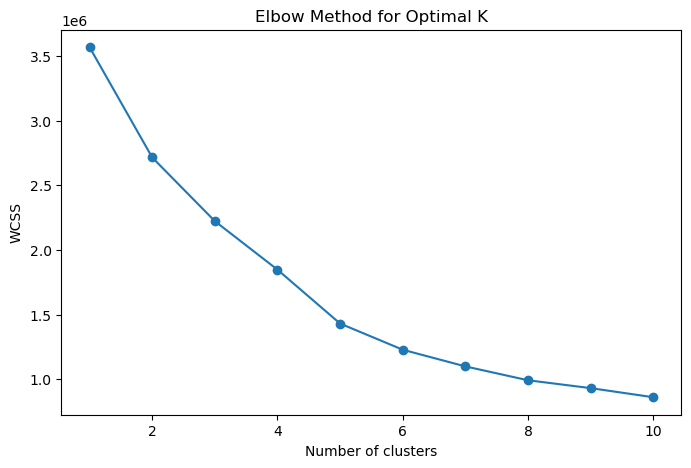

Optimal number of clusters: 5
Optimal number of PCA components to retain 90% variance: 4


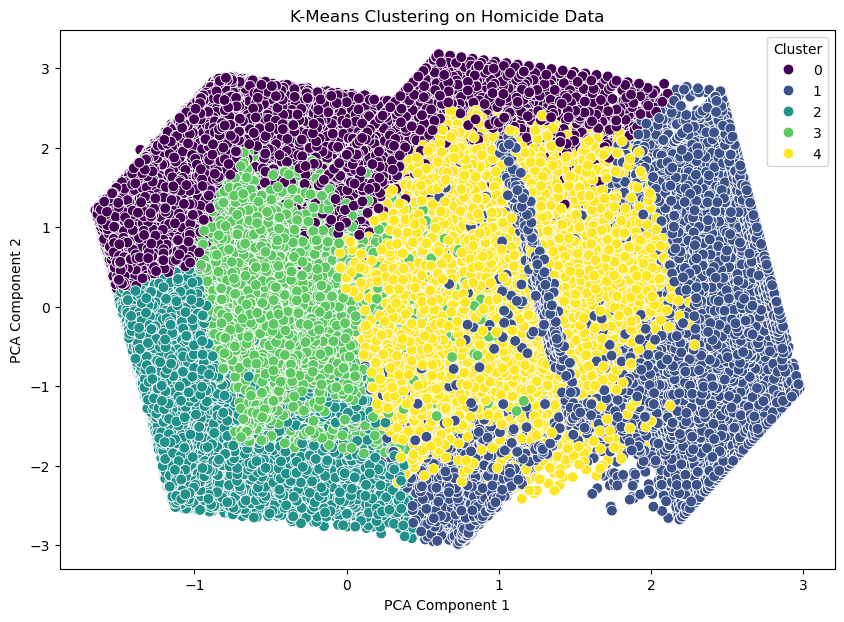


Cluster Analysis:
Optimal number of clusters: 5
The data has been divided into 5 clusters. Each cluster represents a group of similar cases.
The clusters can be further analyzed to understand patterns or common characteristics within each group, such as age, offender, or type of homicide. This insight can guide potential investigative approaches.

PCA Analysis:
Optimal number of PCA components to retain 90% variance: 4
Using this number of components ensures we retain 90% of the information in the data, while reducing the number of dimensions. This helps visualize the data in fewer dimensions without significant information loss.

Isolation Forest Analysis:
Total records classified as anomalies: 44601
Total records classified as normal: 847464
The Isolation Forest detected potential outliers or anomalies in the dataset, which could represent unique or unusual cases. Further analysis on these cases could reveal rare patterns or unexpected data points, helping to identify cases that sta

In [7]:
# Install the missing package
!pip install kneed geopandas plotly

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.decomposition import PCA
from kneed import KneeLocator  # For automatic elbow detection

# Load Data
df = pd.read_csv('https://github.com/fenago/datasets/raw/refs/heads/main/SHR65_23.zip')

# Ensure essential columns are preserved throughout the data preparation steps
required_columns = ['Year', 'Incident', 'VicAge', 'OffAge']

# Action Plan Execution

# 1. Remove Duplicates
df = df.drop_duplicates()

# 2. Handle Missing Values
columns_to_drop = ['Subcircum', 'FileDate']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns and col not in required_columns])

# Impute moderate missing values for VicAge and OffAge
for col in ['VicAge', 'OffAge']:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# 3. Convert Incorrect Data Types
for col in ['ID', 'CNTYFIPS', 'Ori', 'State', 'Agency', 'Agentype', 'Source', 'Solved', 'Month', 'ActionType',
            'Homicide', 'Situation', 'VicSex', 'VicRace', 'VicEthnic', 'OffSex', 'OffRace', 'OffEthnic',
            'Weapon', 'Relationship', 'Circumstance', 'MSA']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 4. Treat High Cardinality and Encoding
encoder = OrdinalEncoder()
if 'ID' in df.columns:
    df['ID'] = encoder.fit_transform(df[['ID']])

# 5. Outlier Detection and Treatment
for col in required_columns:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

for col in required_columns:
    if col in df.columns:
        z_scores = stats.zscore(df[col])
        df[col] = df[col].where(z_scores.abs() <= 3, other=df[col].median())

# 6. Scaling for High Range Columns
scaler = StandardScaler()
for col in required_columns:
    if col in df.columns:
        df[[col]] = scaler.fit_transform(df[[col]])

# 7. Remove Low-Variance Columns
low_variance_cols = [col for col in df.columns if df[col].nunique() == 1 and col not in required_columns]
df = df.drop(columns=low_variance_cols)

# 8. Address Highly Correlated Columns
numeric_df = df[required_columns].select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr().abs()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_cols = [column for column in upper.columns if any(upper[column] > 0.8) and column not in required_columns]
df = df.drop(columns=highly_correlated_cols, errors='ignore')

# 9. Identify Potential Index Columns
if 'ID' in df.columns:
    df.set_index('ID', inplace=True)

# Clustering Analysis

# Step 1: Determine Optimal Number of Clusters with the Elbow Method
if all(col in df.columns for col in required_columns):
    X = df[required_columns].dropna()
    X_scaled = scaler.fit_transform(X)
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Automatically detect the elbow point
    knee_locator = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
    optimal_k = knee_locator.elbow
    print(f"Optimal number of clusters: {optimal_k}")

    # Step 2: K-Means Clustering with Optimal K
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Determine Optimal Number of PCA Components
    pca = PCA().fit(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_pca_components = np.argmax(explained_variance >= 0.90) + 1
    print(f"Optimal number of PCA components to retain 90% variance: {optimal_pca_components}")

    # Applying PCA with optimal components
    pca = PCA(n_components=optimal_pca_components)
    X_pca = pca.fit_transform(X_scaled)
    df_pca = pd.DataFrame(X_pca, columns=[f'PCA{i+1}' for i in range(optimal_pca_components)])

    # Ensure unique index for plotting
    df = df.reset_index(drop=True)
    df_pca = df_pca.reset_index(drop=True)
    df_pca['Cluster'] = df['Cluster']  # Add cluster labels to PCA DataFrame for plotting

    # Visualize the first two PCA components with K-Means Clusters
    if optimal_pca_components >= 2:
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=60)
        plt.title("K-Means Clustering on Homicide Data")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend(title="Cluster")
        plt.show()

    # Step 3: Isolation Forest for Anomaly Detection
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    df['Anomaly'] = iso_forest.fit_predict(X_scaled)

# Analysis Output
print("\nCluster Analysis:")
print(f"Optimal number of clusters: {optimal_k}")
print(f"The data has been divided into {optimal_k} clusters. Each cluster represents a group of similar cases.")
print("The clusters can be further analyzed to understand patterns or common characteristics within each group, "
      "such as age, offender, or type of homicide. This insight can guide potential investigative approaches.")

print("\nPCA Analysis:")
print(f"Optimal number of PCA components to retain 90% variance: {optimal_pca_components}")
print("Using this number of components ensures we retain 90% of the information in the data, "
      "while reducing the number of dimensions. This helps visualize the data in fewer dimensions without significant information loss.")

print("\nIsolation Forest Analysis:")
anomalies_count = (df['Anomaly'] == -1).sum()
normal_count = (df['Anomaly'] == 1).sum()
print(f"Total records classified as anomalies: {anomalies_count}")
print(f"Total records classified as normal: {normal_count}")
print("The Isolation Forest detected potential outliers or anomalies in the dataset, which could represent unique or unusual cases. "
      "Further analysis on these cases could reveal rare patterns or unexpected data points, "
      "helping to identify cases that stand out significantly from the norm.")


In [8]:
# Install the missing package
!pip install kneed geopandas plotly

C:\Users\sudwa\AppData\Local\Temp\ipykernel_11504\106006551.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


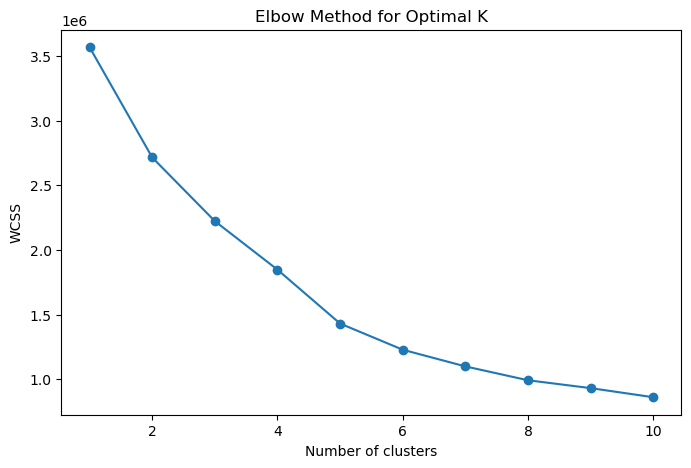

Optimal number of clusters: 5
Optimal number of PCA components to retain 90% variance: 4


C:\Users\sudwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


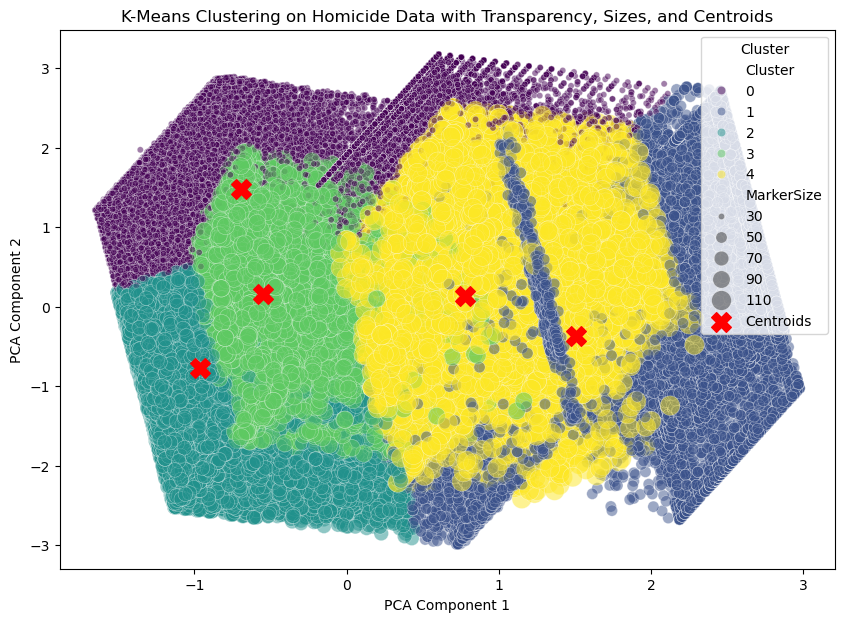


Cluster Analysis:
Optimal number of clusters: 5
The data has been divided into 5 clusters. Each cluster represents a group of similar cases.
The clusters can be further analyzed to understand patterns or common characteristics within each group, such as age, offender, or type of homicide. This insight can guide potential investigative approaches.

PCA Analysis:
Optimal number of PCA components to retain 90% variance: 4
Using this number of components ensures we retain 90% of the information in the data, while reducing the number of dimensions. This helps visualize the data in fewer dimensions without significant information loss.

Isolation Forest Analysis:
Total records classified as anomalies: 44601
Total records classified as normal: 847464
The Isolation Forest detected potential outliers or anomalies in the dataset, which could represent unique or unusual cases. Further analysis on these cases could reveal rare patterns or unexpected data points, helping to identify cases that sta

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator  # For automatic elbow detection

# Load Data
df = pd.read_csv('https://github.com/fenago/datasets/raw/refs/heads/main/SHR65_23.zip')

# Ensure essential columns are preserved throughout the data preparation steps
required_columns = ['Year', 'Incident', 'VicAge', 'OffAge']

# Action Plan Execution

# 1. Remove Duplicates
df = df.drop_duplicates()

# 2. Handle Missing Values
columns_to_drop = ['Subcircum', 'FileDate']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns and col not in required_columns])

# Impute moderate missing values for VicAge and OffAge
for col in ['VicAge', 'OffAge']:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# 3. Convert Incorrect Data Types
for col in ['ID', 'CNTYFIPS', 'Ori', 'State', 'Agency', 'Agentype', 'Source', 'Solved', 'Month', 'ActionType',
            'Homicide', 'Situation', 'VicSex', 'VicRace', 'VicEthnic', 'OffSex', 'OffRace', 'OffEthnic',
            'Weapon', 'Relationship', 'Circumstance', 'MSA']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 4. Treat High Cardinality and Encoding
encoder = OrdinalEncoder()
if 'ID' in df.columns:
    df['ID'] = encoder.fit_transform(df[['ID']])

# 5. Outlier Detection and Treatment
for col in required_columns:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

for col in required_columns:
    if col in df.columns:
        z_scores = stats.zscore(df[col])
        df[col] = df[col].where(z_scores.abs() <= 3, other=df[col].median())

# 6. Scaling for High Range Columns
scaler = StandardScaler()
for col in required_columns:
    if col in df.columns:
        df[[col]] = scaler.fit_transform(df[[col]])

# 7. Remove Low-Variance Columns
low_variance_cols = [col for col in df.columns if df[col].nunique() == 1 and col not in required_columns]
df = df.drop(columns=low_variance_cols)

# 8. Address Highly Correlated Columns
numeric_df = df[required_columns].select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr().abs()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_cols = [column for column in upper.columns if any(upper[column] > 0.8) and column not in required_columns]
df = df.drop(columns=highly_correlated_cols, errors='ignore')

# 9. Identify Potential Index Columns
if 'ID' in df.columns:
    df.set_index('ID', inplace=True)

# Clustering Analysis

# Step 1: Determine Optimal Number of Clusters with the Elbow Method
if all(col in df.columns for col in required_columns):
    X = df[required_columns].dropna()
    X_scaled = scaler.fit_transform(X)
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Automatically detect the elbow point
    knee_locator = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
    optimal_k = knee_locator.elbow
    print(f"Optimal number of clusters: {optimal_k}")

    # Step 2: K-Means Clustering with Optimal K
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Determine Optimal Number of PCA Components
    pca = PCA().fit(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_pca_components = np.argmax(explained_variance >= 0.90) + 1
    print(f"Optimal number of PCA components to retain 90% variance: {optimal_pca_components}")

    # Applying PCA with optimal components
    pca = PCA(n_components=optimal_pca_components)
    X_pca = pca.fit_transform(X_scaled)
    df_pca = pd.DataFrame(X_pca, columns=[f'PCA{i+1}' for i in range(optimal_pca_components)])

    # Ensure unique index for plotting
    df = df.reset_index(drop=True)
    df_pca = df_pca.reset_index(drop=True)
    df_pca['Cluster'] = df['Cluster']  # Add cluster labels to PCA DataFrame for plotting

    # Define marker sizes for each cluster
    marker_sizes = {0: 30, 1: 50, 2: 70, 3: 90, 4: 110}  # Customize these sizes as needed
    df_pca['MarkerSize'] = df_pca['Cluster'].map(marker_sizes)

    # Visualization with transparency, different marker sizes, and centroids
    # Calculate centroids
    centroids = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, size='MarkerSize', sizes=(20, 200), palette='viridis', alpha=0.5)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='red', s=200, marker='X', label="Centroids")  # Red 'X' markers for centroids
    plt.title("K-Means Clustering on Homicide Data with Transparency, Sizes, and Centroids")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()

    # # Step 3: T-SNE Visualization
    # tsne = TSNE(n_components=2, random_state=42)
    # X_tsne = tsne.fit_transform(X_scaled)
    # df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    # df_tsne['Cluster'] = df['Cluster']  # Add the cluster labels

    # plt.figure(figsize=(10, 7))
    # sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=df_tsne, palette='viridis', s=60, alpha=0.6)
    # plt.title("K-Means Clustering on Homicide Data (T-SNE Visualization)")
    # plt.xlabel("TSNE Component 1")
    # plt.ylabel("TSNE Component 2")
    # plt.legend(title="Cluster")
    # plt.show()

    # Step 4: Isolation Forest for Anomaly Detection
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    df['Anomaly'] = iso_forest.fit_predict(X_scaled)

# Analysis Output
print("\nCluster Analysis:")
print(f"Optimal number of clusters: {optimal_k}")
print(f"The data has been divided into {optimal_k} clusters. Each cluster represents a group of similar cases.")
print("The clusters can be further analyzed to understand patterns or common characteristics within each group, "
      "such as age, offender, or type of homicide. This insight can guide potential investigative approaches.")

print("\nPCA Analysis:")
print(f"Optimal number of PCA components to retain 90% variance: {optimal_pca_components}")
print("Using this number of components ensures we retain 90% of the information in the data, "
      "while reducing the number of dimensions. This helps visualize the data in fewer dimensions without significant information loss.")

print("\nIsolation Forest Analysis:")
anomalies_count = (df['Anomaly'] == -1).sum()
normal_count = (df['Anomaly'] == 1).sum()
print(f"Total records classified as anomalies: {anomalies_count}")
print(f"Total records classified as normal: {normal_count}")
print("The Isolation Forest detected potential outliers or anomalies in the dataset, which could represent unique or unusual cases. "
      "Further analysis on these cases could reveal rare patterns or unexpected data points, "
      "helping to identify cases that stand out significantly from the norm.")
